# **Predicción de género cinematográfico con PLN clásico**

In [ ]:
!pip install spacy tqdm pandas scikit-learn matplotlib seaborn textblob
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 43.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [24]:
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import spacy

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from tqdm import tqdm

# Configuración visual
pd.set_option('display.max_colwidth', 200)
sns.set(style="whitegrid", palette="pastel")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
# Montar Google Drive y cargar el CSV desde tu carpeta PLN_Proyecto
from google.colab import drive
drive.mount('/content/drive')

# Ruta a tu archivo (ajusta el nombre del CSV real)
file_path = "/content/drive/MyDrive/PLN_Proyecto/data/films_clean.csv"

# Cargar el dataset
df = pd.read_csv(file_path)

print("Dimensiones:", df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dimensiones: (5332, 6)


,film_name,film_avg_rate,review_rate,review_title,review_text,gender
0,La liberación,4.5,5,"Bien, sin más...Me voy raudo y veloz a ver The Exorcist. Quizás vaya ya por la vez número 100.","""Desde que hace ya más de 50 años que William Peter Blatty primero y, William Friedkin después, concibieran el mito de The Exorcist, nunca jamás nada volvió a ser igual. Decenas de producciones he...","['Terror', 'Intriga']"
1,La liberación,4.5,1,"Tenemos versión cristiana, evangélica …cuándo la de cienciología?","Ya la has visto antes de verla en otras 200 películas del mismo estilo que salieron post El Exorcista, y lo único que tiene de nuevo es que es una versión hecha por y para evangelistas. Nada abso...","['Terror', 'Intriga']"
2,La liberación,4.5,1,Esto no es terror amigos,"""Hay que puntualizar que no es una peli de terror, sino un dramón barato digno de antena 3 a la hora de la sobremesa. """"La Ebony"""" (se han comido el tarro con el nombre el guionista) de hortaleza ...","['Terror', 'Intriga']"
3,La liberación,4.5,4,Liberación la nuestra,"La carrera de Lee Daniels es cuanto menos irregular. Desde la muy sobrevalorada Precious hasta El mayordomo, quizás lo más brillante de su filmografía sea el biopic de Billie Holiday, que ya tenía...","['Terror', 'Intriga']"
4,La liberación,4.5,2,El terror que nunca llega,"""Intenta sumergirnos en el clásico subgénero del terror de casas encantadas, mezclando elementos sobrenaturales con un trasfondo de intriga. La trama sigue a una familia que se muda a una casa en ...","['Terror', 'Intriga']"


La columna gender tiene listas como texto **("['Terror', 'Intriga']")**, así que primero hay que convertirlas a listas reales de Python

In [26]:
import ast

def safe_eval(val):
    return val if isinstance(val, list) else ast.literal_eval(val)

df['gender'] = df['gender'].apply(safe_eval)

df[['film_name', 'gender']].head(10)


,film_name,gender
0,La liberación,"[Terror, Intriga]"
1,La liberación,"[Terror, Intriga]"
2,La liberación,"[Terror, Intriga]"
3,La liberación,"[Terror, Intriga]"
4,La liberación,"[Terror, Intriga]"
5,La liberación,"[Terror, Intriga]"
6,La liberación,"[Terror, Intriga]"
7,La liberación,"[Terror, Intriga]"
8,La liberación,"[Terror, Intriga]"
9,Príncipes salvajes,[Drama]


# **Análisis Exploratorio Inicial**

In [27]:
# Combinaciones únicas de géneros que existen en el dataset
df['gender'].apply(tuple).value_counts().head(15)

,count
gender,
"(Comedia, Drama, Ciencia ficción)",320
"(Thriller, Drama)",291
"(Drama, Aventuras)",271
"(Western, Drama)",229
"(Intriga, Thriller, Drama)",204
"(Thriller, Intriga, Crimen)",141
"(Bélico, Acción, Drama)",138
"(Drama,)",128
"(Intriga, Comedia, Crimen)",125


Las combinaciones más comunes son:

- (Comedia, Drama, Ciencia ficción) → 320 casos

- (Thriller, Drama) → 291 casos

- (Drama, Aventuras) → 271 casos

También hay muchas combinaciones con 3 géneros, lo que sugiere que el modelo debe aprender interacciones entre géneros.

**Esto permite decidir si se va a entrenar el modelo para predecir géneros individuales o combinaciones completas (lo más común es predecir géneros individuales).**

num_genres
3    2253
2    1949
4     509
1     460
5     156
6       3
8       2
Name: count, dtype: int64


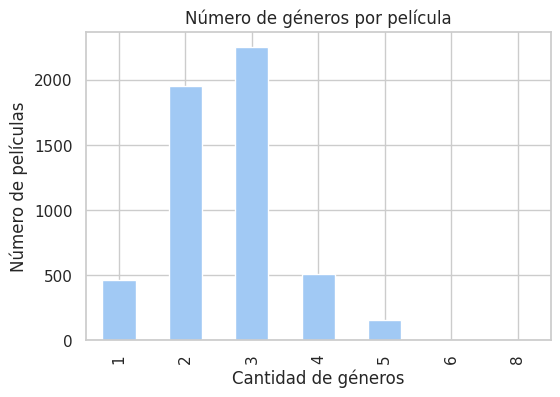

In [28]:
# Número de géneros por película
df['num_genres'] = df['gender'].apply(len)

# Distribución
print(df['num_genres'].value_counts())

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df['num_genres'].value_counts().sort_index().plot(kind='bar')
plt.title("Número de géneros por película")
plt.xlabel("Cantidad de géneros")
plt.ylabel("Número de películas")
plt.show()


- La mayoría de las películas tienen 2 o 3 géneros (más de 4000 casos combinados).

- olo 460 películas tienen un solo género.

- **Casos con 5 o más géneros son muy raros → pueden ser ruidosos o difíciles de clasificar.**

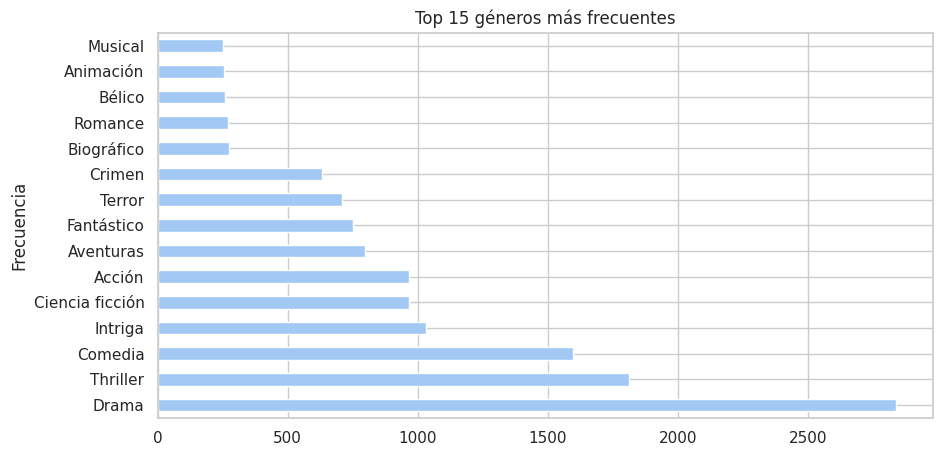

In [29]:
from collections import Counter

# Flatten de todas las listas
all_genres = [g for sublist in df['gender'] for g in sublist]
genre_counts = Counter(all_genres)

# Mostrar los 15 más frecuentes
import pandas as pd
pd.Series(genre_counts).sort_values(ascending=False).head(15).plot(kind='barh', figsize=(10,5))
plt.title("Top 15 géneros más frecuentes")
plt.ylabel("Frecuencia")
plt.show()


In [ ]:
# Filtrar ejemplos con 'Terror'
ej_terror = df[df['gender'].apply(lambda x: 'Terror' in x)].head(3)

# Mostrar texto y géneros
for i, row in ej_terror.iterrows():
    print(f"\nTítulo: {row['film_name']}")
    print(f"Géneros: {row['gender']}")
    print(f"Reseña: {row['review_text'][:300]}...")



Título: La liberación 
Géneros: ['Terror', 'Intriga']
Reseña: "Desde que hace ya más de 50 años que William Peter Blatty primero y, William Friedkin después, concibieran el mito de The Exorcist, nunca jamás nada volvió a ser igual. Decenas de producciones hechas, las cuales, ni siquiera han conseguido rozar el acercamiento a The Exorcist.Ello no quita que haya...

Título: La liberación 
Géneros: ['Terror', 'Intriga']
Reseña: Ya la has visto antes de verla en otras 200 películas del mismo estilo que salieron post El Exorcista, y lo único que tiene de nuevo es que  es una versión hecha por y para evangelistas. Nada absolutamente nada nuevo en este diablo que trepa paredes como Spiderman.La única que se salva en todo este ...

Título: La liberación 
Géneros: ['Terror', 'Intriga']
Reseña: "Hay que puntualizar que no es una peli de terror, sino un dramón barato digno de antena 3 a la hora de la sobremesa. ""La Ebony"" (se han comido el tarro con el nombre el guionista) de hortaleza sufrido

Las reseñas mencionan elementos clásicos del terror y la intriga, lo que valida que el modelo puede aprender a asociar texto con géneros.

In [30]:
# Mostrar ejemplos por género
def mostrar_ejemplos(género, n=3):
    ejemplos = df[df['gender'].apply(lambda x: género in x)].head(n)
    for i, row in ejemplos.iterrows():
        print(f"\n🎬 Título: {row['film_name']}")
        print(f"🎭 Géneros: {row['gender']}")
        print(f"📝 Reseña: {row['review_text'][:300]}...")

# Ejemplos variados
for g in ['Drama', 'Comedia', 'Ciencia ficción', 'Crimen', 'Romance']:
    print(f"\n🔎 Ejemplos para género: {g}")
    mostrar_ejemplos(g)



🔎 Ejemplos para género: Drama

🎬 Título: Príncipes salvajes 
🎭 Géneros: ['Drama']
📝 Reseña: América Latina es el continente más desigual del mundo. África presenta mayores niveles de pobreza, pero en América Latina es donde las diferencias de clase resultan mas sangrantes. Con un porcentaje de la sociedad de personas ricas que viven en el lujo y la opulencia y una gran mayoría del pueblo q...

🎬 Título: Pretty Guardian Sailor Moon Cosmos: La película 
🎭 Géneros: ['Animación', 'Fantástico', 'Acción', 'Comedia', 'Drama', 'Aventuras', 'Romance', 'Terror']
📝 Reseña: Sailor Moon ha sido desde los 90' uno de mis animes favoritos, y creo que uno de los primeros que vi (antes de saber que se les llamaba anime), aunque la versión de los 90' no era fiel al manga y era un poco repetitiva, me pareció una muy buena adaptación que disfruté muchísimo hasta el capítulo fin...

🎬 Título: Pretty Guardian Sailor Moon Cosmos: La película 
🎭 Géneros: ['Animación', 'Fantástico', 'Acción', 'Comedia', 'Drama

Se seleccionaron ejemplos representativos de reseñas para géneros frecuentes como Drama, Comedia, Ciencia ficción, Crimen y Romance. En cada caso, se observó que el texto contiene elementos temáticos, estilísticos y narrativos coherentes con el género asignado. Esta validación confirma que las reseñas son una fuente adecuada para inferir géneros mediante técnicas de PLN.


- Las reseñas de Drama hablan de desigualdad social, conflictos humanos, introspección → coherente con el género.

- Las de Comedia usan humor adolescente, referencias sexuales, tono ligero → claramente cómico.

- Las de Ciencia ficción mencionan directores, universos, tecnología, referencias a Star Wars → muy representativas.

- Las de Crimen hablan de detectives, corrupción, persecuciones → semántica típica del género.

- Las de Romance incluyen relaciones, emociones, nostalgia, vínculos afectivos → bien alineadas.

En resumen los textos contienen:

- **Diversidad semántica:** cada género tiene un estilo, vocabulario y enfoque distinto.

- **Combinaciones reales:** muchas reseñas tienen múltiples géneros, lo que valida el enfoque multietiqueta.

- **Contexto narrativo:** las reseñas no solo describen la trama, sino también el tono, el ritmo y la atmósfera — todo útil para inferir género.

Esto demuestra que el modelo puede aprender a asociar texto con géneros, incluso cuando hay varios simultáneamente.

In [31]:
# Verificar valores nulos
print(df.isnull().sum())

# Verificar si hay textos vacíos
print("Textos vacíos:", (df['review_text'].str.strip() == '').sum())


film_name        0
film_avg_rate    0
review_rate      0
review_title     0
review_text      0
gender           0
num_genres       0
dtype: int64
Textos vacíos: 0


count    5332.000000
mean      249.980683
std       191.271503
min         8.000000
25%       114.000000
50%       192.000000
75%       322.000000
max      1084.000000
Name: text_length, dtype: float64


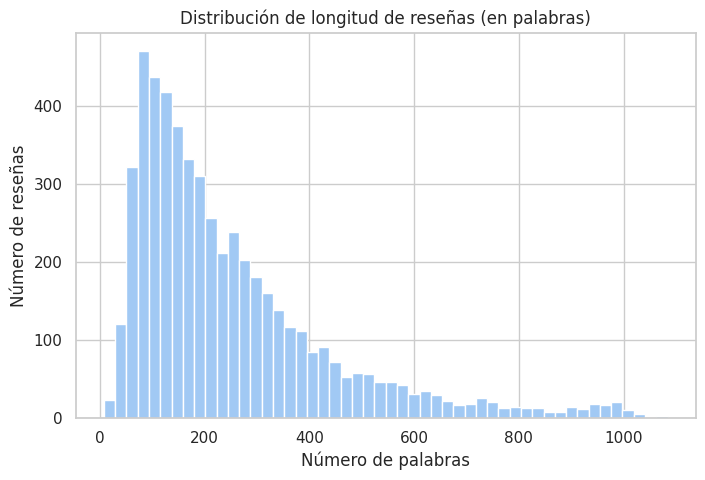

In [32]:
# Longitud de cada reseña
df['text_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Estadísticas descriptivas
print(df['text_length'].describe())

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
df['text_length'].hist(bins=50)
plt.title("Distribución de longitud de reseñas (en palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Número de reseñas")
plt.show()


- Distribución: sesgada a la derecha (muchas reseñas entre 100 – 300 palabras, pocas muy largas)

- Mínimo: 8 palabras → se podría considerar eliminar reseñas muy cortas si no aportan semántica útil.

In [33]:
# Calcular longitud en palabras
df['text_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Filtrar reseñas con al menos 10 palabras
df = df[df['text_length'] >= 20].copy()

# Verificar nuevo tamaño
print("Nuevo tamaño del dataset después de filtrar reseñas cortas:", df.shape)

# Longitud de cada reseña
df['text_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Estadísticas descriptivas
print(df['text_length'].describe())


Nuevo tamaño del dataset después de filtrar reseñas cortas: (5327, 8)
count    5327.000000
mean      250.202928
std       191.223540
min        21.000000
25%       114.000000
50%       192.000000
75%       322.000000
max      1084.000000
Name: text_length, dtype: float64


Se eliminaron del corpus todas las reseñas con menos de 10 palabras, dado que no aportan suficiente contenido semántico para inferir géneros de forma fiable. Esta decisión mejora la calidad del texto de entrada y reduce el ruido en el entrenamiento del modelo.

El umbral de longitud mínima se definió en función de la distribución de palabras por reseña. Dado que la mayoría de reseñas superan ampliamente las 100 palabras y solo un caso tenía menos de 10, se estableció un umbral conservador de 20 palabras. Este criterio elimina textos demasiado breves que carecen de información semántica, sin afectar significativamente el tamaño del corpus.


**Se optó por conservar todos los géneros presentes en el dataset, incluso aquellos con baja frecuencia, para preservar la riqueza semántica y la diversidad temática. En caso de que el modelo presente bajo rendimiento en géneros minoritarios, se aplicarán técnicas de data augmentation textual, oversampling multietiqueta y ajuste de penalización por clase para mejorar la capacidad de generalización sin comprometer la cobertura.**


# GENERADOR DE DATOS SINTÉTICOS ???

# **Preprocesamiento de etiquetas (géneros) :**

Las etiquetas de género se **binarizan** directamente mediante **MultiLabelBinarizer**, ya que son categorías discretas y no requieren normalización lingüística.

De esta manera, se obtiene una matriz de etiquetas (**y**)

In [34]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Inicializar el binarizador
mlb = MultiLabelBinarizer()

# Ajustar y transformar la columna 'gender'
y = mlb.fit_transform(df['gender'])

# Ver los géneros detectados
print("Géneros posibles:", mlb.classes_)

# Convertir a DataFrame para visualizar mejor
y_df = pd.DataFrame(y, columns=mlb.classes_)

# Mostrar las primeras filas
print(y_df.head())


Géneros posibles: ['Acción' 'Animación' 'Aventuras' 'Biográfico' 'Bélico' 'Ciencia ficción'
 'Cine negro' 'Comedia' 'Comedia negra' 'Crimen' 'Documental' 'Drama'
 'Fantástico' 'Histórico' 'Intriga' 'Musical' 'Romance' 'Terror'
 'Thriller' 'Western']
   Acción  Animación  Aventuras  Biográfico  Bélico  Ciencia ficción  \
0       0          0          0           0       0                0   
1       0          0          0           0       0                0   
2       0          0          0           0       0                0   
3       0          0          0           0       0                0   
4       0          0          0           0       0                0   

   Cine negro  Comedia  Comedia negra  Crimen  Documental  Drama  Fantástico  \
0           0        0              0       0           0      0           0   
1           0        0              0       0           0      0           0   
2           0        0              0       0           0      0           0 

Las etiquetas de género se transformaron mediante MultiLabelBinarizer,
convirtiendo cada lista de géneros en un vector binario.
De esta forma, cada reseña queda representada por una fila en la matriz
y cada género por una columna, con valores 0/1 que indican su presencia.
Esta representación es necesaria para entrenar modelos multietiqueta
y evaluar métricas específicas por género.


# **Preprocesamiento de texto :**

El proceso de limpieza y normalización de texto es un paso crucial en el procesamiento del lenguaje natural (NLP). Este proceso implica varias técnicas para preparar el texto original para su análisis, mejorando la calidad y la relevancia de los datos. De esta manera, se transforma el texto en lenguaje natural a un formato entendible para modelos de aprendizaje automático y algoritmos de NLP.

A continuación, se describen algunas de las técnicas más comunes utilizadas en el preprocesamiento de texto en español.

1. **Normalización:** Se realiza para homogeneizar el texto y reducir la variabilidad. Esto incluye:

- **Conversión del texto a minúsculas:** homogeneiza el texto (p. ej. "Casa"→"casa").
- **Corrección de errores tipográficos:** se busca corregir errores comunes de escritura.
- **Convertir números a una representación estándar:** por ejemplo, transformar "dos" en "2".
- **Eliminar signos de puntuación:** se eliminan signos de puntuación que no aportan significado, como .,;:¡!¿?.
- **Eliminar o reemplazar acentos:** es habitual reemplazar las vocales acentuadas (á, é, í, ó, ú) por su versión sin tilde (a, e, i, o, u). Esto unifica términos que solo difieren en acentuación (por ejemplo “información” → “informacion”) y reduce el tamaño del vocabulario.
- **Manejo de contracciones y abreviaturas:** expandir contracciones comunes (p. ej. “del” → “de el”) y abreviaturas (p. ej. "Sr." → "Señor").
- **Manejo de emojis y emoticonos:** se pueden eliminar
- **Eliminar espacios en blanco:** se eliminan espacios adicionales al inicio, final y entre palabras (p. ej. " hola " → "hola").

2. **Eliminación de ruido:** Esto incluye la eliminación de caracteres no deseados, como HTML, etiquetas XML, o cualquier otro tipo de ruido que no aporte valor al análisis.

3. **Tokenización:** Es el proceso de dividir el texto en unidades más pequeñas, llamadas tokens. En español, esto puede ser un desafío debido a la riqueza morfológica del idioma.

4. **Lematización y stemming:** Estas técnicas buscan reducir las palabras a su forma base o raíz. La lematización considera el contexto y la gramática, mientras que el stemming simplemente corta los sufijos.

5. **Eliminación de stopwords:** Las stopwords son palabras comunes que no aportan significado relevante al análisis, como *“y”, “el”, “de”,* etc. Su eliminación puede ayudar a mejorar la calidad del modelo.

6. **Extracción de características:** Finalmente, se pueden extraer características relevantes del texto, como n-gramas, que pueden ser útiles para tareas de clasificación o análisis de sentimientos.

In [36]:
import re
import string

# Diccionarios personalizables
CONTRACCIONES = {
    "del": "de el",
    "al": "a el"
}

ABREVIATURAS = {
    "sr.": "señor",
    "sra.": "señora",
    "dr.": "doctor",
    "dra.": "doctora",
    "etc.": "etcetera",
    "p. ej.": "por ejemplo",
    "ee.uu.": "estados unidos",
    "dpto.": "departamento",
    "nro.": "numero",
    "núm.": "numero",
    "film.": "film",
    "dir.": "director",
    # coloquiales útiles en reseñas
    "peli": "pelicula",
    "docu": "documental",
    "bio": "biografico"
}

def limpiar_texto(text: str) -> str:
    """
    Preprocesa el texto realizando los siguientes pasos:
    1. Minúsculas.
    2. Eliminación de acentos de vocales.
    3. Expansión de contracciones (del->de el, al->a el).
    4. Expansión de abreviaturas (Sr.->Señor, peli->pelicula, etc.).
    5. Eliminación de textos entre corchetes.
    6. Eliminación de URLs.
    7. Eliminación de etiquetas HTML.
    8. Eliminación de signos de puntuación.
    9. Eliminación de saltos de línea.
    10. Eliminación de palabras con números.
    11. Eliminación de emojis y caracteres no ASCII (excepto ñ).
    12. Normalización de espacios y strip.

    Args:
        text: Texto original.

    Returns:
        Texto preprocesado y normalizado.
    """
    # 1) Minúsculas
    text = str(text).lower()

    # 2) Eliminar acentos de vocales
    MAP_VOCALES = {"á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u", "ü": "u"}
    text = text.translate(str.maketrans(MAP_VOCALES))

    # 3) Expansión de contracciones (del, al)
    for k, v in CONTRACCIONES.items():
        # límites de palabra para evitar reemplazos parciales
        text = re.sub(rf"\b{re.escape(k)}\b", v, text)

    # 4) Expansión de abreviaturas comunes y coloquiales
    # orden: primero las que tienen punto para evitar que la eliminación de puntuación las desfigure
    for k, v in ABREVIATURAS.items():
        text = re.sub(rf"\b{re.escape(k)}\b", v, text)

    # 5) Eliminar textos entre corchetes
    text = re.sub(r"\[.*?\]", "", text)

    # 6) Eliminar URLs
    text = re.sub(r"https?://\S+|www\.\S+", "", text)

    # 7) Eliminar etiquetas HTML
    text = re.sub(r"<.*?>+", "", text)

    # 8) Eliminar signos de puntuación
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # 9) Eliminar saltos de línea
    text = re.sub(r"\n", " ", text)

    # 10) Eliminar palabras que contienen números (ej. abc123)
    text = re.sub(r"\w*\d\w*", "", text)

    # 11) Eliminar emojis y caracteres especiales (no ASCII), excepto ñ
    text = re.sub(r"[^\x00-\x7Fñ]+", "", text)

    # 12) Normalizar espacios múltiples y strip
    text = re.sub(r"\s+", " ", text).strip()

    return text


In [37]:
df["clean_review"] = df["review_text"].apply(limpiar_texto)

# Vista previa del resultado
df[['review_text', 'clean_review']].head()

,review_text,clean_review
0,"""Desde que hace ya más de 50 años que William Peter Blatty primero y, William Friedkin después, concibieran el mito de The Exorcist, nunca jamás nada volvió a ser igual. Decenas de producciones he...",desde que hace ya mas de años que william peter blatty primero y william friedkin despues concibieran el mito de the exorcist nunca jamas nada volvio a ser igual decenas de producciones hechas las...
1,"Ya la has visto antes de verla en otras 200 películas del mismo estilo que salieron post El Exorcista, y lo único que tiene de nuevo es que es una versión hecha por y para evangelistas. Nada abso...",ya la has visto antes de verla en otras peliculas de el mismo estilo que salieron post el exorcista y lo unico que tiene de nuevo es que es una version hecha por y para evangelistas nada absolutam...
2,"""Hay que puntualizar que no es una peli de terror, sino un dramón barato digno de antena 3 a la hora de la sobremesa. """"La Ebony"""" (se han comido el tarro con el nombre el guionista) de hortaleza ...",hay que puntualizar que no es una pelicula de terror sino un dramon barato digno de antena a la hora de la sobremesa la ebony se han comido el tarro con el nombre el guionista de hortaleza sufrido...
3,"La carrera de Lee Daniels es cuanto menos irregular. Desde la muy sobrevalorada Precious hasta El mayordomo, quizás lo más brillante de su filmografía sea el biopic de Billie Holiday, que ya tenía...",la carrera de lee daniels es cuanto menos irregular desde la muy sobrevalorada precious hasta el mayordomo quizas lo mas brillante de su filmografia sea el biopic de billie holiday que ya tenia a ...
4,"""Intenta sumergirnos en el clásico subgénero del terror de casas encantadas, mezclando elementos sobrenaturales con un trasfondo de intriga. La trama sigue a una familia que se muda a una casa en ...",intenta sumergirnos en el clasico subgenero de el terror de casas encantadas mezclando elementos sobrenaturales con un trasfondo de intriga la trama sigue a una familia que se muda a una casa en i...


In [38]:
import spacy
from tqdm import tqdm

# Cargar modelo de spaCy en español
nlp = spacy.load("es_core_news_sm", disable=["ner", "parser"])

def procesar_spacy(textos, batch_size=64):
    """
    Procesa una lista de textos normalizados con spaCy.
    - Tokeniza automáticamente.
    - Permite aplicar stopwords y lematización.
    """
    return nlp.pipe(textos, batch_size=batch_size)

def limpiar_tokens(doc, eliminar_stopwords=True, min_len=3, usar_lematizacion=True):
    """
    Limpia tokens de un documento spaCy:
    1. Elimina stopwords (si eliminar_stopwords=True).
    2. Filtra tokens muy cortos (min_len).
    3. Usa lematización (token.lemma_) o forma superficial (token.text).
    """
    tokens = []
    for token in doc:
        if eliminar_stopwords and token.is_stop:
            continue
        if token.is_punct or token.is_space:
            continue
        if len(token) < min_len:
            continue
        tokens.append(token.lemma_ if usar_lematizacion else token.text)
    return tokens

def construir_texto(tokens):
    """Une tokens limpios en un texto único."""
    return " ".join(tokens).strip()

# Aplicar a tu columna ya normalizada
texts = df["clean_review"].tolist()
cleaned_texts = []

print("Procesando con spaCy...")

for doc in tqdm(procesar_spacy(texts, batch_size=64)):
    toks = limpiar_tokens(doc, eliminar_stopwords=True, min_len=3, usar_lematizacion=True)
    cleaned_texts.append(construir_texto(toks))

df["final_clean"] = cleaned_texts

# Vista previa
df[["review_text", "clean_review", "final_clean"]].head()


Procesando con spaCy...


5327it [01:21, 65.64it/s] 


,review_text,clean_review,final_clean
0,"""Desde que hace ya más de 50 años que William Peter Blatty primero y, William Friedkin después, concibieran el mito de The Exorcist, nunca jamás nada volvió a ser igual. Decenas de producciones he...",desde que hace ya mas de años que william peter blatty primero y william friedkin despues concibieran el mito de the exorcist nunca jamas nada volvio a ser igual decenas de producciones hechas las...,año william peter blatty william friedkin concibierar mito the exorcist jama volver decena producción hecho siquiera conseguir rozar acercamiento the exorcistello quitar haber haber producción per...
1,"Ya la has visto antes de verla en otras 200 películas del mismo estilo que salieron post El Exorcista, y lo único que tiene de nuevo es que es una versión hecha por y para evangelistas. Nada abso...",ya la has visto antes de verla en otras peliculas de el mismo estilo que salieron post el exorcista y lo unico que tiene de nuevo es que es una version hecha por y para evangelistas nada absolutam...,haber ver ver él pelicula estilo salir post exorcista unico version hecho evangelista absolutamente diablo trepa pared spidermanla unico salir refrito glenn c él él tonto papel pelicula mejora pre...
2,"""Hay que puntualizar que no es una peli de terror, sino un dramón barato digno de antena 3 a la hora de la sobremesa. """"La Ebony"""" (se han comido el tarro con el nombre el guionista) de hortaleza ...",hay que puntualizar que no es una pelicula de terror sino un dramon barato digno de antena a la hora de la sobremesa la ebony se han comido el tarro con el nombre el guionista de hortaleza sufrido...,puntualizar pelicula terror dramon barato digno antena hora sobremesa ebony comer tarro nombre guionista hortaleza sufridor intentar sacar familia lidiar adiccion alcohol dej engañar pertenecer ge...
3,"La carrera de Lee Daniels es cuanto menos irregular. Desde la muy sobrevalorada Precious hasta El mayordomo, quizás lo más brillante de su filmografía sea el biopic de Billie Holiday, que ya tenía...",la carrera de lee daniels es cuanto menos irregular desde la muy sobrevalorada precious hasta el mayordomo quizas lo mas brillante de su filmografia sea el biopic de billie holiday que ya tenia a ...,carrera lee daniels irregular sobrevalorado precious mayordomo brillante filmografia biopic billie holiday tener andra day protagonistair ocasion daniel day unir contarno historia posesion supuest...
4,"""Intenta sumergirnos en el clásico subgénero del terror de casas encantadas, mezclando elementos sobrenaturales con un trasfondo de intriga. La trama sigue a una familia que se muda a una casa en ...",intenta sumergirnos en el clasico subgenero de el terror de casas encantadas mezclando elementos sobrenaturales con un trasfondo de intriga la trama sigue a una familia que se muda a una casa en i...,intentar sumergirno clasico subgenero terror casa encantado mezclar elemento sobrenatural trasfondo intriga trama familia mudar casa indiana descubrir lugar albergar fuerza oscuro demoniaca medida...


El preprocesamiento se realizó en dos fases:
1. Normalización inicial (minúsculas, eliminación de acentos, URLs, HTML, puntuación, emojis).
2. Procesamiento lingüístico con spaCy:
   - Tokenización automática.
   - Eliminación de stopwords.
   - Lematización de tokens restantes.
   
El resultado es una columna 'final_clean' con textos homogéneos y semánticamente más consistentes,
listos para vectorización y entrenamiento multietiqueta.


In [40]:
print(nlp.vocab["él"].is_stop)  # Debería devolver True


True


# **Análisis Exploratorio Post-Preprocesamiento**

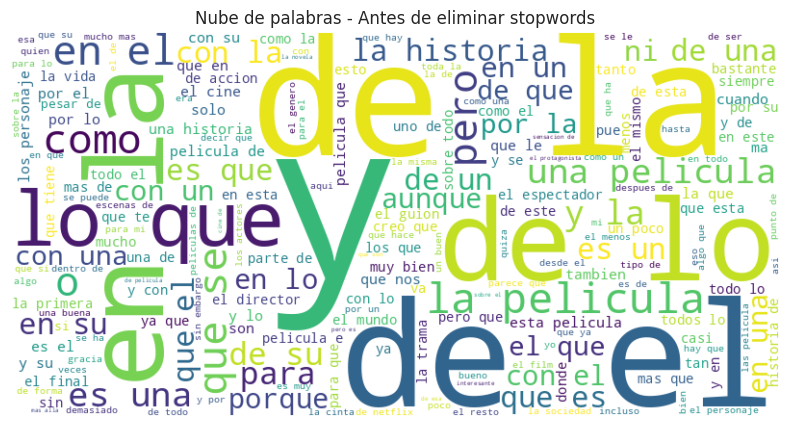

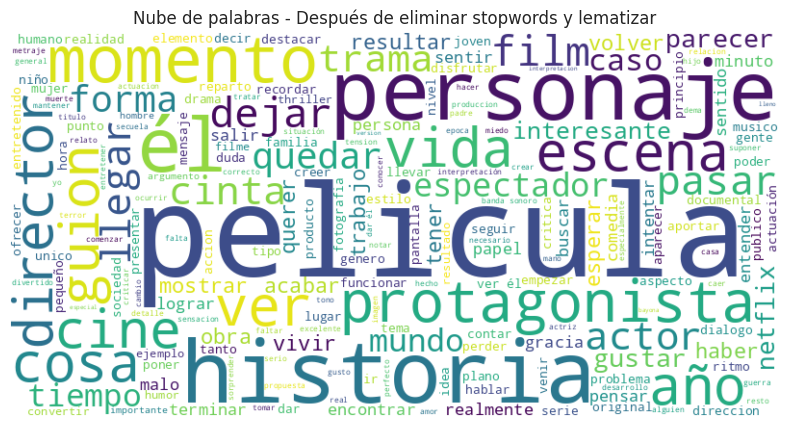

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Nube de palabras antes de eliminar stopwords (clean_review)
text_before = " ".join(df["clean_review"])
wc_before = WordCloud(width=800, height=400, background_color="white").generate(text_before)

plt.figure(figsize=(10,5))
plt.imshow(wc_before, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Antes de eliminar stopwords")
plt.show()

# Nube de palabras después de eliminar stopwords y lematizar (final_clean)
text_after = " ".join(df["final_clean"])
wc_after = WordCloud(width=800, height=400, background_color="white").generate(text_after)

plt.figure(figsize=(10,5))
plt.imshow(wc_after, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Después de eliminar stopwords y lematizar")
plt.show()


Se realizó una exploración post-procesamiento para validar la efectividad del pipeline.
Se compararon frecuencias de palabras y nubes de palabras antes y después de eliminar stopwords y aplicar lematización.
Los resultados muestran que el corpus limpio concentra términos semánticamente relevantes (géneros, temas narrativos)
y elimina ruido funcional, confirmando la utilidad del preprocesamiento para la vectorización.


# **Vectorización del texto (TF-IDF)**

División inicial de los datos en entrenamiento y prueba.


In [ ]:
# Dividir datos
X = df['clean_text']
y = df['gender']

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2, stratify=y_train_full, random_state=42
)


In [ ]:
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)



In [ ]:
print("Dimensiones del conjunto de entrenamiento:", X_train_tfidf.shape)
print("Dimensiones del conjunto de prueba:", X_val_tfidf.shape)
print("Dimensiones del conjunto de prueba:", X_test_tfidf.shape)

# Mostrar las primeras 20 palabras del vocabulario
print("Primeras palabras del vocabulario TF-IDF:")
print(vectorizer.get_feature_names_out()[:100])

> **El corpus fue dividido en tres subconjuntos: entrenamiento (64%), validación (16%) y prueba (20%). Esta estructura permite entrenar modelos sobre el conjunto de entrenamiento, evaluar su rendimiento en validación para ajustar hiperparámetros y detectar problemas como desbalance de clases, y finalmente realizar una evaluación objetiva sobre el conjunto de prueba. La vectorización se realizó con TF-IDF sobre el texto limpio, utilizando unigramas como línea base.**


Aunque eliminar palabras poco frecuentes ayuda a reducir la dimensionalidad y el ruido textual, también implica el riesgo de perder términos informativos que aparecen en pocos documentos. Por ello, se evaluaron modelos con y sin filtros de frecuencia mínima, comparando su rendimiento y capacidad para distinguir géneros con vocabulario especializado. Esta estrategia permite encontrar un equilibrio entre limpieza y preservación semántica.
